# ENVIRONMENT SETTING & HYPER-PARAMETER DEFINITION

In [0]:
%tensorflow_version 1.x

import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
T = 2 # EXPANSION FACTOR
P_list = [10, 50, 200] # NUMBER OF NODES IN COMPRESSED LAYER
m = 28 # INPUT WIDTH
n = 28 # INPUT HEIGHT
MPI = 1 # MAXIMUM PIXEL INTENSITY

# REAL EXPERIMENT




Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_53 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_159 (Dense)            (None, 10)                7850      
_________________________________________________________________
dense_160 (Dense)            (None, 1568)              17248     
_________________________________________________________________
dense_161 (Dense)            (None, 784)               1230096   
_________________________________________________________________
reshape_53 (Reshape)         (None, 28, 28, 1)         0         
Total params: 1,255,194
Trainable params: 1,255,194
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples
Epoch 1/10
60000/60000 - 24s - loss: 0.0222
Epoch 2/10
60000/60000 - 21s - loss: 0.

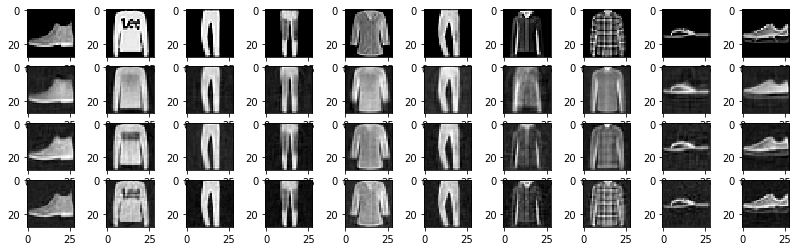

In [0]:
# INPUT DIMENSION - [28*28], since our input layer is flattened
fashion_mnist = datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.reshape((60000, m, n, 1))
test_images = test_images.reshape((10000, m, n, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0 # NORMALIZATION
train_target, test_target = train_images, test_images
# DATA SAMPLING
plt.figure(figsize=(14,4))
for index,image in enumerate(test_images[0:10]):
    plt.subplot(4, 10, index + 1)
    plt.imshow(np.reshape(image, (m, n)), cmap=plt.cm.gray)
idx = 0
test_loss, test_psnr = [], []
test_target = test_target.reshape((test_target.shape[0], test_target.shape[1]*test_target.shape[2]))
for P in P_list:
    print("\n\n")
    # MODEL CREATION
    model = models.Sequential()
    model.add(layers.Input(shape=(m, n, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(P, input_dim=m*n))
    model.add(layers.Dense(m*n*T, activation="relu", input_dim=P))
    model.add(layers.Dense(m*n, input_dim=m*n*T))
    model.add(layers.Reshape((m, n, 1)))
    model.summary()

    # MODEL COMPILATION
    model.compile(optimizer="adam", loss="mean_squared_error")

    # MODEL FITTING
    model.fit(train_images, train_target, epochs=10, batch_size=64, verbose=2)

    # MODEL EVALUATION
    predictions_mat = model.predict(test_images).reshape((test_target.shape[0], test_target.shape[1]))
    loss_list = np.square(test_target - predictions_mat)
    loss_list = [sum(i)/len(i) for i in loss_list]
    psnr_list = [10 * math.log(MPI*MPI/loss, 10) for loss in loss_list]
    test_loss.insert(idx, sum(loss_list)/len(loss_list))
    test_psnr.insert(idx, sum(psnr_list)/len(psnr_list))

    idx = idx + 1
    # DATA SAMPLING
    for index,image in enumerate(predictions_mat[0:10]):
        plt.subplot(4, 10, 10*idx + index + 1)
        plt.imshow(np.reshape(image, (m, n)), cmap=plt.cm.gray)

for i in range(3):
    print("\nWHEN P = %d" % (P_list[i]))
    print("TEST LOSS: %.4f" % (test_loss[i]))
    print("TEST PSNR: %.4f" % (test_psnr[i]))